# Optimization for Collabrative filtering

## Imports

In [75]:
import numpy as np
import pandas as pd
import lenskit.crossfold as xf
import matplotlib.pyplot as plt
from lenskit.metrics.predict import rmse
from lenskit.algorithms.bias import Bias
from lenskit.batch import predict

In [76]:
from functions import *

# A. Preprocessing of data

1. Data format

We are going to preprocess a rating file in the following csv format:  
```
UserID::MovieID::Rating::Timestamp
```

2. Prepare data for cross-validation

Splitting Data for a user-based N-fold cross-validation. Store each partition into a new csv file. 

It is convinient to use a python package lenskit. It can be installed by following https://lkpy.readthedocs.io/en/stable/install.html

Use the function lenskit.crossfold.partition_rows to partition all the ratings into N train-test partitions.

3. Convert to a list format

Convert data into a list format for fast processing


In [77]:
# read a DataFrame of ratings from the csv ratings file
csvroot = 'data' 
ratings = pd.read_csv(csvroot + '/ratings.csv')
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})

lst_users, dic_users = unique(ratings['user'])
lst_items, dic_items = unique(ratings['item'])
M = len(lst_users)
N = len(lst_items)

matrixSparsity = len(ratings) / (M*N)
print("We have %d users, %d movies and the %d ratings matrix has %f percent of non-zero value.\n" % (M, N,ratings.shape[0],100*matrixSparsity))

We have 610 users, 9724 movies and the 100836 ratings matrix has 1.699968 percent of non-zero value.



In [78]:
# 2 fold cross-validation, store each partition (both train and test) in a seperate csv file.
# Point 1: report the number of (user,iter,rating) items in each file.
df = ratings

# Create 2 folds using partition_rows
folds = xf.partition_rows(df, 2)

# Iterate over the folds and write each partition to a separate CSV file
for i, (train, test) in enumerate(folds):
    
    train = train.rename(columns={'userId': 'user', 'movieId': 'item'})
    test = test.rename(columns={'userId': 'user', 'movieId': 'item'})

    train.to_csv(f'data/train_{i}.csv', index=False)
    test.to_csv(f'data/test_{i}.csv', index=False)
    

    # Print the number of (user, item, rating) items in each partition
    print(f'fold {i}')


    lst_users, dic_users = unique(train['user'])
    lst_items, dic_items = unique(train['item'])
    Ml = len(lst_users)
    Nl = len(lst_items)
    matrixSparsity = len(ratings) / (M*N)
    print("We have %d users, %d movies and %d rating \n" % (Ml, Nl,train.shape[0]))


    lst_users, dic_users = unique(test['user'])
    lst_items, dic_items = unique(test['item'])
    Ml = len(lst_users)
    Nl = len(lst_items)

    print("We have %d users, %d movies and %d rating \n" % (Ml, Nl,test.shape[0]))
    



fold 0
We have 610 users, 7530 movies and 50418 rating 

We have 610 users, 7491 movies and 50418 rating 

fold 1
We have 610 users, 7491 movies and 50418 rating 

We have 610 users, 7530 movies and 50418 rating 



In [79]:
# read the csv files from a partition of the cross-validation
# convert them to RDD using convert_DF_to_RDD

# Read the train and test sets for a specific fold 0 from CSV files
train_0_df = pd.read_csv(csvroot+ '/train_0.csv')
test_0_df = pd.read_csv(csvroot+ '/test_0.csv')

# Convert the train and test sets to RDDs using convert_DF_to_RDD
train_0_rdd = convert_DF_to_RDD(train_0_df)
test_0_rdd = convert_DF_to_RDD(test_0_df)


# Read the train and test sets for a specific fold 1 from CSV files
train_1_df = pd.read_csv(csvroot+ '/train_1.csv')
test_1_df = pd.read_csv(csvroot+ '/test_1.csv')

# Convert the train and test sets to RDDs using convert_DF_to_RDD
train_1_rdd = convert_DF_to_RDD(train_1_df)
test_1_rdd = convert_DF_to_RDD(test_1_df)


# B. Gradient-descent algorithm

Based on the preprocessing, we are going to develop a method to find optimal P and Q on training data. It contains: 

1. compute the objective and the gradient of the objective function
2. implement the gradient-descent algroithm
3. measure the speed of this method

In [80]:
# use a random P and Q to test the function computeMSE
# Point 2: report MSE with LAMBDA=0
K = 14 # rank parameter (best chose)
P = np.random.rand(M,K) # user's features matrix (M by K)
Q = np.random.rand(N,K) # item's features matrix (N by K)

ratings_rdd = convert_DF_to_RDD(ratings)
print('MSE =',  computeMSE(ratings_rdd,P,Q))

MSE = 1.8210351572290786


mse : 1.817712462204949
reg_mse : 1.817712462219475
1
mse : 1.8116900189057523
reg_mse : 1.8116900189926395
2
mse : 1.8057765787047417
reg_mse : 1.8057765789220968
3
mse : 1.7999691511033242
reg_mse : 1.799969151506834
4
mse : 1.7942648435841453
reg_mse : 1.7942648442303244
5
mse : 1.7886608581568437
reg_mse : 1.7886608591325872
6
mse : 1.7831544880016081
reg_mse : 1.7831544893978855
7
mse : 1.7777431142149445
reg_mse : 1.7777431161196362
8
mse : 1.7724242027323216
reg_mse : 1.7724242052299308
9
mse : 1.7671953013391424
reg_mse : 1.767195304511479
10


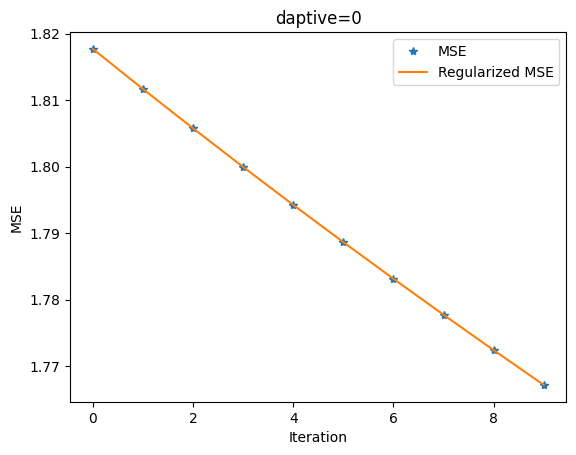

In [81]:

# Compare GD constant step size with GD line search step size
# Point 3: Make plots to show how (regularized) MSE changes with respect to GD iterations 
# Mention your initialization of P,Q, and the stopping criterion of GD

### TODO


def run_gd(RDD, M, N, K, MAXITER , GAMMA, LAMBDA, adaptive):
    # Run the gradient descent algorithm
    P, Q, lreg_mse, lmse = GD(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive)
    # Plot the MSE at each iteration
    plt.plot(range(MAXITER), lmse,'*', label='MSE')
    plt.plot(range(MAXITER), lreg_mse, label='Regularized MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title(f'daptive={adaptive}')
    plt.legend()
    plt.show()
    return P,Q 
# Set the hyperparameters
MAXITER = 10
GAMMA = 0.1
LAMBDA = 0.001

# Generate random data for RDD
RDD =ratings_rdd

# Run the gradient descent algorithm with a constant step size
P, Q = run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=0)




mse : 6.210914268702801
reg_mse : 6.210914268702801
1
mse : 6.197403754970032
reg_mse : 6.197403754970032
2
mse : 6.183957742919508
reg_mse : 6.183957742919508
3
mse : 6.170575695646213
reg_mse : 6.170575695646213
4
mse : 6.157257082124784
reg_mse : 6.157257082124784
5
mse : 6.144001377138007
reg_mse : 6.144001377138007
6
mse : 6.1308080612067135
reg_mse : 6.1308080612067135
7
mse : 6.117676620521445
reg_mse : 6.117676620521445
8
mse : 6.104606546873942
reg_mse : 6.104606546873942
9
mse : 6.091597337590305
reg_mse : 6.091597337590305
10
mse : 6.078648495464745
reg_mse : 6.078648495464745
11
mse : 6.065759528693858
reg_mse : 6.065759528693858
12
mse : 6.052929950811834
reg_mse : 6.052929950811834
13
mse : 6.040159280627351
reg_mse : 6.040159280627351
14
mse : 6.027447042159523
reg_mse : 6.027447042159523
15
mse : 6.0147927645765895
reg_mse : 6.0147927645765895
16
mse : 6.002195982133801
reg_mse : 6.002195982133801
17
mse : 5.9896562341134985
reg_mse : 5.9896562341134985
18
mse : 5.97717

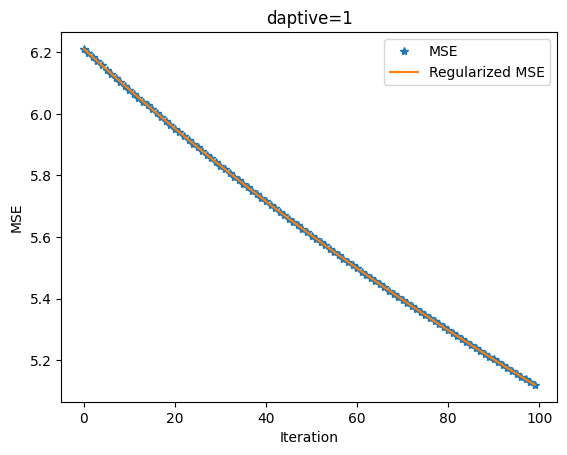

In [46]:
# Run the gradient descent algorithm with a line search step size
P1, Q1 = run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=1)

# C. Perofomance evaluation
1. Compute RMSE score. You should use lenskit.metrics.predict.rmse for a fair comparison. Analyze both the training and test score on the 5 cross-validation partitions. 
2. Compare with a baseline method called Bias. Tune the hyper-parameters such as K and lambda to see if you can obtain a smaller RMSE. Try to explain why. 

In [55]:
# Point 4: Report RMSE, together with your choice of K,LAMBDA and GD parameters
import lenskit

In [91]:
import math

In [95]:

def evaluate_rmse(RDD, P, Q):
    """ 
    This function computes the root MSE score on the rating of RDD. It compares the rating of each (i,j)
    in RDD, with the prediction made by <p_i,q_j>. 
    Args:
        RDD: a dict of list of users, items, ratings
        P: optimal P found by GD
        Q: optimal Q found by GD
    Returns:
        RMSE: the RMSE score
    """
    
    # Get the lists of users, items, and ratings from the RDD
    users = RDD['users']
    items = RDD['items']
    ratings = RDD['ratings']
    unique_items, items_dict = unique(items)
    users_items, users_dict = unique(users)
    
    # Initialize a list to store the predicted ratings
    preds = []
    
    # Loop through the ratings
    for idx in range(len(ratings)):
        # Get the user ID and item ID for the current rating
        user_id = users_dict[users[idx]]
        item_id = items_dict[items[idx]]
        p = P[user_id]
        q = Q[item_id]
        
        # Compute the predicted rating using the dot product of P and Q
        rating = np.dot(p,q)
        
        # Append the predicted rating to the list
        preds.append(rating)
    
    # Compute the RMSE score
    rmse_score = lenskit.metrics.predict.rmse(ratings,preds)
    print(preds-ratings)
    return rmse_score

rmse_score = evaluate_rmse(ratings_rdd,P,Q)
print(rmse_score)


[-0.4044273  -0.99733389  0.18565319 ... -0.44831876  0.57268
  0.21946322]
2.2705344020086784


In [44]:
# Compare the performance with a baseline method called Bias
# see in https://lkpy.readthedocs.io/en/stable/bias.html
# Point 5:  report the RMSE of the baseline method, and analyze the results
# Hint: use read_csv in panda to read you csv data

from lenskit.algorithms.bias import Bias
from lenskit.batch import predict

### TODO


In [42]:
# Split the data into training and test sets
train_df = train_0_df
test_df = test_0_df

# Train the Bias model on the training data
model = Bias()
model.fit(train_df)

# Make predictions on the test data
predictions = predict(model, test_df)

# Calculate the RMSE of the predictions
rmse_bias = np.sqrt(lenskit.metrics.predict.rmse(predictions.rating, test_df.rating))
print(f'RMSE of Bias method: {rmse_bias}')


RMSE of Bias method: 0.0
